In [ ]:
#default_exp bogacz

# Bogacz 2017

**Abstract**:

This paper provides an easy to follow tutorial on the free-energy framework for modelling perception
developed by Friston, which extends the predictive coding model of Rao and Ballard. These models assume
that the sensory cortex infers the most likely values of attributes or features of sensory stimuli from
the noisy inputs encoding the stimuli. Remarkably, these models describe how this inference could be
implemented in a network of very simple computational elements, suggesting that this inference could be
performed by biological networks of neurons. Furthermore, learning about the parameters describing the
features and their uncertainty is implemented in these models by simple rules of synaptic plasticity based
on Hebbian learning. This tutorial introduces the free-energy framework using very simple examples, and
provides step-by-step derivations of the model. It also discusses in more detail how the model could be
implemented in biological neural circuits. In particular, it presents an extended version of the model in
which the neurons only sum their inputs, and synaptic plasticity only depends on activity of pre-synaptic
and post-synaptic neurons.

In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
#export
from typing import Callable
from collections import namedtuple
# Science & Math
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

In [ ]:
#|export
# Configuration
plt.style.use('seaborn')

## 2. Simplest Example of Perception


Consider a simple organism tries to infer size of food from ligh intensity
* Light intensity, $g(v)$, relates to surface area of food, $v$, according to $g(v) = v^2$
* Using light-receptors, organisms noisily estimates light intensity with mean $g(v)$ and variance $\Sigma_u$

The likelihood of the organism sensing a particular light intensity, $u$, given some food size $v$ is:
$$
p(u | v) = \text{Normal}(u; \text{mean}=g(v), \text{std dev}=\Sigma_u)
$$

The organism has some idea of reasonable food sizes, and it takes this prior knowledge into account when sensing the light; food can't be outrageously small or large, so any light detected probably comes from food that is around some average size $v_p$ with variance $\Sigma_p$ ("p" stands for "prior"):
$$
p(v) = \text{Normal}(v; v_p, \Sigma_p)
$$

But how does the organisms combine the likelihood and prior to best estimate the food size from light intensity?

### 2.1 Exact Solution

A while ago, some big-brain humans came up with a mathematically best way to combine prior and likelihood. This is **Baye's Theorem**:
$$
p(v | u) = \frac{p(u | v) p(v)}{p(u)}
$$

In words we have:
* Right hand side: The chance that the true food size is $v$ based on the estimated light intensity $u$
* Left hand side: the chance that this particular food size $v$ would produce that particular estimated light intensity $u$ AND the chance that the organism would even encounter food with size $v$, out of all the ways the organism could have estimated that particular light intensity $u$

#### Exercise 1

In [ ]:
#export

def exercise1():
    # --- Hypotheses
    possible_food_sizes = np.linspace(0.01, 5.0, num=100)

    # --- Priors
    prior_food_size = dict(avg=3, variance=1) # v_p and Sigma_p
    priors = stats.norm(prior_food_size['avg'], prior_food_size['variance']).pdf(possible_food_sizes)

    # --- Data
    estimated_light_intensity = 2 # u 
    noisyness_of_estimate = 1 # Sigma_u

    # --- Likelihoods
    light_intensity_likelihood = stats.norm(estimated_light_intensity, noisyness_of_estimate)
    # Remember that light_intensity(food_size) = food_size ** 2
    possible_light_intensities = possible_food_sizes ** 2
    likelihoods = light_intensity_likelihood.pdf(possible_light_intensities) # p(u | v)

    # --- Posterior
    probs_of_possible_food_sizes = likelihoods * priors / np.sum(likelihoods * priors) # p(v | u)
    # Interval width helps us convert between probability and probability densities
    hypothesis_interval_width = possible_food_sizes[1] - possible_food_sizes[0]
    prob_densities_of_possible_food_sizes = probs_of_possible_food_sizes / hypothesis_interval_width
    return possible_food_sizes, probs_of_possible_food_sizes

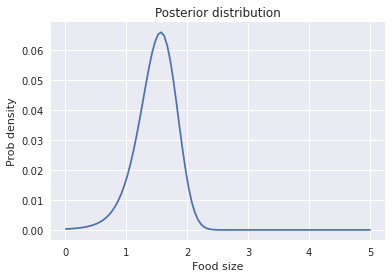

In [ ]:
possible_food_sizes, probs_of_possible_food_sizes = exercise1()
fig, ax = plt.subplots(1, 1)
ax.plot(possible_food_sizes, probs_of_possible_food_sizes)
ax.set_xlabel('Food size')
ax.set_ylabel('Prob density')
ax.set_title('Posterior distribution')
plt.show()

### 2.2 Finding the most likely feature value

But this organism can't do fancy math like us. So how would a living thing with a nervous system combine the likelihood and prior in the best way possible?

Instead of calculating the whole posterior distribution, the organism probably calculates just the most likely food size, which we'll call $\phi$. So, the actual probability of $\phi$ given the observed light intensity is $p(\phi | v)$.

Notice that if we plugin $v = \phi$ into Bayes Theorem, only the numerator of the left hand has anything to do with $\phi$. 

$$
p(\phi | u) = \frac{p(u | \phi) p(\phi)}{p(u)}
$$

To a simple organism there's no point in calculating the denominator, except to waste brain power. It probably just calculates some variation of the numerator. A computationally convenient variation of the numerator is the natural log version. We'll call the natural log version of the numerator $F$.

$$
F = \ln \bigg( p(u | \phi) p(\phi) \bigg) = \ln p(u | \phi) + \ln p(\phi)
$$

Let's assume the organism's nervous system iteratively searches for $\phi$ to maximize $F$; it starts with some initial guess for $\phi$, then nudges it little by little until it's confident it has reached a $\phi$ with the highest probability of explaining the observed light intensity. But how does it do the nudging?

Gradient ascent is an algorithm that nudges values according to 1) some function and 2) how that function changes as the input changes (i.e. the derivative of the function). Nervous systems have the capability to compute rates of change, so gradient ascent is a realistic algorithm for us to model the organism with.

Check out the paper for the full derivation, but basically when $\phi$ changes a little, then $F$ changes by this much:

$$
\frac{\partial F}{\partial \phi} = \frac{v_p - \phi}{\Sigma_p} + \frac{u - g(\phi)}{\Sigma_u} g'(\phi)
$$

In our example, $g(v) = v^2$ so $g'(v) = 2v$

#### Exercise 2

In [ ]:
#|export
def update(current_guess: float, up: UpdateParams, g: Callable, g_prime: Callable, delta_time: float):
    first_term = (up.prior - current_guess) / up.prior_noise
    second_term = ((up.estimate - g(current_guess)) / up.estimate_noise) * g_prime(current_guess)
    nudge_amnt = first_term + second_term # delta
    return current_guess + nudge_amnt * delta_time

def exercise2():
    prior_food_size = dict(avg=3, variance=1) # v_p and Sigma_p
    estimated_light_intensity = 2 # u 
    noisyness_of_estimate = 1 # Sigma_u
    up = UpdateParams(
        estimated_light_intensity,
        noisyness_of_estimate,
        prior_food_size['avg'],
        prior_food_size['variance'],
    )
    
    total_time = 5
    delta_time = 0.01
    time_series = np.linspace(0, total_time, num=int(int(total_time / delta_time)))
    guesses = np.zeros(len(time_series))
    initial_guess = prior_food_size['avg'] # phi
    guesses[0] = initial_guess
    
    g = lambda v: v*v
    g_prime = lambda v: 2*v
    
    for i, time in enumerate(time_series):
        if i == 0: continue
        guesses[i] = update(guesses[i-1], up, g, g_prime, delta_time)
    return time_series, guesses


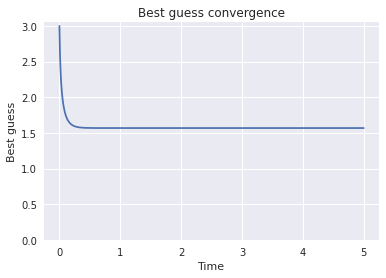

In [ ]:
UpdateParams = namedtuple('UpdateParams', 'estimate estimate_noise prior prior_noise')
time_series, guesses = exercise2()
fig, ax = plt.subplots(1, 1)
ax.plot(time_series, guesses)
ax.set_xlabel('Time')
ax.set_ylabel('Best guess')
ax.set_ylim(0.0, 3.05)
ax.set_title('Best guess convergence')
plt.show()

### 2.3 A possible neural implementation

Let's group the terms in the $F$ derivative equation:

$$
\epsilon_p = \frac{\phi - v_p}{\Sigma_p}
$$

$$
\epsilon_u = \frac{u - g(\phi)}{\Sigma_u}
$$

Which gives us:

$$
\dot{\phi} = \frac{\partial F}{\partial \phi} = \epsilon_u g'(\phi) - \epsilon_p
$$

where $\dot{\phi}$ is a more compact way of writing the derivative of $F$ with respect to $\phi$.

IRL neural circuits encode $v_p$, $\Sigma_p$, and $\Sigma_u$ in the strengths of synaptic connections. After all, the organism needs to remember these quantities.

$\phi$, $\epsilon_p$, $\epsilon_u$, and $u$ change as the activity of populations of neurons change. 

A single neuron, or "node", changes it's activity proportionally to its input. Plus, any prediction error could be computed by:

$$
\dot{\epsilon_p} = \phi - v_p - \Sigma_p \epsilon_p
$$

$$
\dot{\epsilon_u} = u - g(\phi) - \Sigma_u \epsilon_u
$$

When these derivatives are $0$, we get the epsilon equations we defined earlier.

In [ ]:
#|export
def exercise3():
    prior_food_size = dict(avg=3, variance=1) # v_p and Sigma_p
    estimated_light_intensity = 2 # u 
    noisyness_of_estimate = 1 # Sigma_u
    up = UpdateParams(
        estimated_light_intensity,
        noisyness_of_estimate,
        prior_food_size['avg'],
        prior_food_size['variance'],
    )

    total_time = 5
    delta_time = 0.01
    time_series = np.linspace(0, total_time, num=int(int(total_time / delta_time)))
    guesses = np.zeros(len(time_series))
    
    initial_guess = prior_food_size['avg'] # phi
    guesses[0] = initial_guess
    
    error_prior = np.zeros(len(time_series))
    error_prior[0] = 0 # epsilon_p
    error_light_estimate = np.zeros(len(time_series))
    error_light_estimate[0] = 0 # epsilon_u
    
    g_prime = lambda v: 2*v
    
    for i, time in enumerate(time_series):
        guesses[i] = guesses[i-1] + delta_time * (error_light_estimate[i-1] * g_prime(guesses[i-1]) - error_prior[i-1])
        error_prior[i] = error_prior[i-1] + delta_time * (guesses[i-1] - up.estimate - up.estimate_noise * error_prior[i-1])
        error_light_estimate[i] = error_light_estimate[i-1] + delta_time * (up.estimate - guesses[i-1]**2 - up.estimate_noise * error_light_estimate[i-1])
    return time_series, guesses, error_light_estimate, error_prior

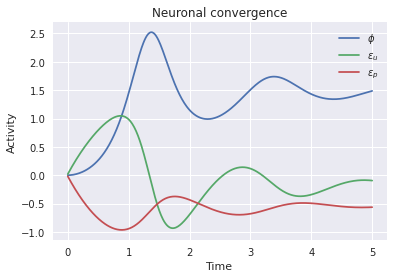

In [ ]:
UpdateParams = namedtuple('UpdateParams', 'estimate estimate_noise prior prior_noise')
time_series, guesses, error_light_estimate, error_prior = exercise3()
fig, ax = plt.subplots(1, 1)
ax.plot(time_series, guesses, label='$\phi$')
ax.plot(time_series, error_light_estimate, label='$\epsilon_u$')
ax.plot(time_series, error_prior, label='$\epsilon_p$')
ax.set_xlabel('Time')
ax.set_ylabel('Activity')
ax.set_title('Neuronal convergence')
plt.legend()
plt.show()